All external packages are installed.


[I 2020-09-23 04:34:22,796] Using an existing study with name 'wavelet' instead of creating a new one.


wandb: Waiting for W&B process to finish, PID 81756
wandb: Program ended successfully.
wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200923_033604-yaffsmd0/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200923_033604-yaffsmd0/logs/debug-internal.log
wandb: Run summary:
wandb:                               train/loss 1.019109919650457e-05
wandb:                               valid/loss 8.079076836584513e-06
wandb:                                    _step 202
wandb:                                 _runtime 191
wandb:                               _timestamp 1600832359
wandb:                                test/loss 3.7098687122070195e-07
wandb:                           Relative Error 12.743952101439202
wandb: Run history:
wandb:       train/loss █▆▄▃▃▃▂▂▂▃▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁
wandb:       valid/loss █▅▄▃▂▆▂▂▆▆▅▂▁▂▂▃▁▂▂▁▃▁▁▁▄▁▂▁▁▂▂▁▁▂▂▁▂▂▂▁
wandb:            _step 


Epoch  1 Train 0.00062 Valid 0.00007
Epoch  2 Train 0.00007 Valid 0.00005
Epoch  3 Train 0.00006 Valid 0.00004
Epoch  4 Train 0.00005 Valid 0.00004
Epoch  5 Train 0.00004 Valid 0.00005
Epoch  6 Train 0.00005 Valid 0.00003
Epoch  7 Train 0.00005 Valid 0.00005
Epoch  8 Train 0.00004 Valid 0.00003
Epoch  9 Train 0.00003 Valid 0.00002
Epoch 10 Train 0.00003 Valid 0.00002
Epoch 11 Train 0.00003 Valid 0.00003
Epoch 12 Train 0.00004 Valid 0.00002
Epoch 13 Train 0.00003 Valid 0.00002
Epoch 14 Train 0.00003 Valid 0.00002
Epoch 15 Train 0.00003 Valid 0.00002
Epoch 16 Train 0.00003 Valid 0.00002
Epoch 17 Train 0.00002 Valid 0.00005
Epoch 18 Train 0.00003 Valid 0.00002
Epoch 19 Train 0.00003 Valid 0.00005
Epoch 20 Train 0.00003 Valid 0.00002
Epoch 21 Train 0.00003 Valid 0.00002
Epoch 22 Train 0.00002 Valid 0.00002
Epoch 23 Train 0.00002 Valid 0.00002
Epoch 24 Train 0.00003 Valid 0.00002
Epoch 25 Train 0.00002 Valid 0.00002
Epoch 26 Train 0.00003 Valid 0.00004
Epoch 27 Train 0.00002 Valid 0.00001


[I 2020-09-23 04:37:41,372] Trial 84 finished with value: 12.743952101439202 and parameters: {'LR': 0.0020808029706961793, 'n_units_F1': 64}. Best is trial 40 with value: 2.957254394006982.


Study statistics: 
  Number of finished trials:  85
  Number of pruned trials:  0
  Number of complete trials:  59
Best trial:
  Value:  2.957254394006982
  Params: 
    LR: 0.00044724719735944797
    n_units_C1: 25
    n_units_C2: 45
    n_units_C3: 26
    n_units_F1: 50
    n_units_F2: 15


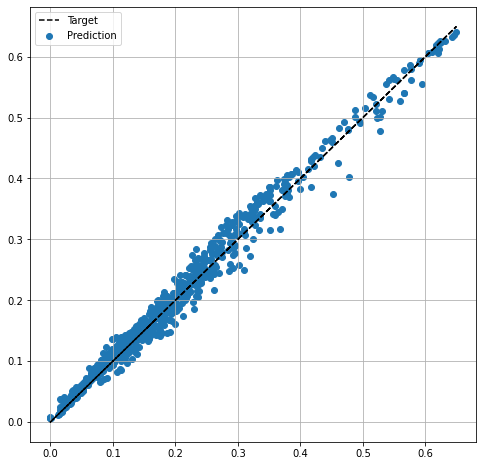

In [34]:
count = 2
while count:
    try:
        from omegaconf import OmegaConf
        import optuna
        import wandb
        print('All external packages are installed.')
        break
    except:
        !pip install omegaconf
        !pip install optuna
        !pip install wandb
        count -= 1
        continue



from skimage.transform import resize
import pywt
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self,trial):
        super(Net, self).__init__()

        #n_units_C1 = trial.suggest_int("n_units_C1", 8, 64)
        #n_units_C2 = trial.suggest_int("n_units_C2", 8, 64)
        #n_units_C3 = trial.suggest_int("n_units_C3", 8, 64)

        #n_units_F1 = trial.suggest_int("n_units_F1", 4, 64)
        #n_units_F2 = trial.suggest_int("n_units_F2", 4, 64)

        n_units_C1 = 25
        n_units_C2 = 45
        n_units_C3 = 26

        n_units_F1 = trial.suggest_int("n_units_F1", 4, 64)
        n_units_F2 = 15

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, n_units_C1, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(n_units_C1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(n_units_C1, n_units_C2, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(n_units_C2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(n_units_C2, n_units_C3, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(n_units_C3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(n_units_C3*49, n_units_F2),#16
            nn.ReLU(),
            nn.Linear(n_units_F2, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0),-1)
        #print(x.size(1))
        x = self.fc_layers(x)
        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_dataset(data_length=400, sample_rate=2e-6):
    # Load CSV Files
    # TODO: Use numpy instead of pandas
    #I_sin_5k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/I(sin_5k_hiB).csv', header=None).iloc[:,1:data_length+1]
    #V_sin_5k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/V(sin_5k_hiB).csv', header=None).iloc[:,1:data_length+1]

    #I_tri_5k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/I(tri_5k_hiB).csv', header=None).iloc[:,1:data_length+1]
    #V_tri_5k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/V(tri_5k_hiB).csv', header=None).iloc[:,1:data_length+1]

    I_trap_5k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/I(trap_5k_hiB).csv', header=None).iloc[:,1:data_length+1]
    V_trap_5k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/V(trap_5k_hiB).csv', header=None).iloc[:,1:data_length+1]

    I_trap_2k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/I(trap_2k_hiB).csv', header=None).iloc[:,1:data_length+1]
    V_trap_2k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/V(trap_2k_hiB).csv', header=None).iloc[:,1:data_length+1]

    I_trap_1k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/I(trap_1k_hiB).csv', header=None).iloc[:,1:data_length+1]
    V_trap_1k = pd.read_csv('drive/My Drive/Colab Notebooks/Data/V(trap_1k_hiB).csv', header=None).iloc[:,1:data_length+1]

    #I = pd.concat([I_sin_5k , I_tri_5k , I_trap_5k], ignore_index=True)
    #V = pd.concat([V_sin_5k , V_tri_5k , V_trap_5k], ignore_index=True)

    I = pd.concat([I_trap_5k , I_tapi_2k , I_trap_1k], ignore_index=True)
    V = pd.concat([V_trap_5k , V_tapi_2k , V_trap_1k], ignore_index=True)

    # Compute scalograms
    wave_name = 'cgau8'
    total_scale = 30
    fc = pywt.central_frequency(wave_name)
    fmax = 10e3
    cparam = (1 / sample_rate) / fmax * fc * total_scale
    scales = cparam / np.arange(total_scale, 1, -1)

    data_size = I.shape[0]
    image_size = 48
    scalogram = np.zeros([data_size, image_size, image_size])
    for index, row in V.iterrows():
        cwtmatr, _ = pywt.cwt(row, scales, wave_name, sample_rate)
        scalogram[index] = resize(abs(cwtmatr), (image_size, image_size))
        if index % 1000 == 0:
            print(f"Index {index} finished")

    # Compute labels
    P = V * I

    t = np.arange(0, (data_length-0.5) * sample_rate, sample_rate)
    Loss_meas = np.trapz(P, t, axis=1) / (sample_rate * data_length)
    
    #Loss_meas = np.log10(Loss_meas)

    # Reshape data
    in_tensors = torch.from_numpy(scalogram).view(-1, 1, image_size, image_size)
    out_tensors = torch.from_numpy(Loss_meas).view(-1, 1)

    # Save data as CSV
    np.save("dataset.wavelet.in.npy", in_tensors.numpy())
    np.save("dataset.wavelet.out.npy", out_tensors.numpy())

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)


def load_dataset(in_filename="dataset.wavelet.in.npy", out_filename="dataset.wavelet.out.npy"):
    in_tensors = torch.from_numpy(np.load(in_filename))
    out_tensors = torch.from_numpy(np.load(out_filename))

    return torch.utils.data.TensorDataset(in_tensors, out_tensors)


def objective(trial):
    # Load Configuration
    YAML_CONFIG = OmegaConf.load("drive/My Drive/Colab Notebooks/wavelet.yaml")
    CLI_CONFIG = OmegaConf.from_cli()
    DEFAULT_CONFIG = OmegaConf.merge(YAML_CONFIG, CLI_CONFIG)

    # Get hyperparameters from Optuna
    OPTUNA_CONFIG = OmegaConf.create({
        "LR": trial.suggest_loguniform("LR", 1e-5, 1e-2),
    })
    CONFIG = OmegaConf.merge(DEFAULT_CONFIG, OPTUNA_CONFIG)

    # Reproducibility
    random.seed(CONFIG.SEED)
    np.random.seed(CONFIG.SEED)
    torch.manual_seed(CONFIG.SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Setup CPU or GPU
    if CONFIG.USE_GPU and not torch.cuda.is_available():
        raise ValueError("GPU not detected but CONFIG.USE_GPU is set to True.")
    device = torch.device("cuda")
    #device = torch.device("cpu")
    #device = xm.xla_device()

    # Setup dataset and dataloader
    # NOTE(seungjaeryanlee): Load saved dataset for speed

    #dataset = get_dataset()

    count = 2
    while count:
        try:
            dataset = load_dataset()
            break
        except:
            dataset = get_dataset()
            continue

    train_size = int(0.6 * len(dataset))
    valid_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - valid_size
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
    kwargs = {'num_workers': 1, 'pin_memory': True} if CONFIG.USE_GPU else {}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, **kwargs)

    # Setup neural network and optimizer
    net = Net(trial).double().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.00044724719)  #lr=CONFIG.LR
    # Log number of parameters
    CONFIG.NUM_PARAMETERS = count_parameters(net)

    # Setup wandb
    wandb.init(project="MagNet", config=CONFIG)
    wandb.watch(net)

    # Training
    for epoch_i in range(1, CONFIG.NUM_EPOCH+1):
        # Train for one epoch
        epoch_train_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Compute Validation Loss
        with torch.no_grad():
            epoch_valid_loss = 0
            for inputs, labels in valid_loader:
                outputs = net(inputs.to(device))
                loss = criterion(outputs, labels.to(device))

                epoch_valid_loss += loss.item()

        print(f"Epoch {epoch_i:2d} "
            f"Train {epoch_train_loss / len(train_dataset):.5f} "
            f"Valid {epoch_valid_loss / len(valid_dataset):.5f}")
        wandb.log({
             "train/loss": epoch_train_loss / len(train_dataset),
             "valid/loss": epoch_valid_loss / len(valid_dataset),
         })

    # Evaluation
    net.eval()
    y_meas = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            y_pred.append(net(inputs.to(device)))
            y_meas.append(labels.to(device))

    y_meas = torch.cat(y_meas, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    print(f"Test Loss: {F.mse_loss(y_meas, y_pred).item() / len(test_dataset):.8f}")
    wandb.log({"test/loss": F.mse_loss(y_meas, y_pred).item() / len(test_dataset)})

    # Predicton vs Target Plot
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax.scatter(y_meas.cpu().numpy(), y_pred.cpu().numpy(), label="Prediction")
    ax.plot(y_meas.cpu().numpy(), y_meas.cpu().numpy(), 'k--', label="Target")
    ax.grid(True)
    ax.legend()
    wandb.log({"prediction_vs_target": wandb.Image(fig)})
    
    y_pred = y_pred.cpu().numpy()
    #y_pred = 10**y_pred
    y_meas = y_meas.cpu().numpy()
    #y_meas = 10**y_meas

    # Relative Error
    Error_re1 = abs(y_pred-y_meas)/abs(y_meas)*100
    Error_re1[np.where(Error_re1>500)] = 500
    # Error_re_max1 = np.max(Error_re1);
    Error_re_avg1 = np.mean(Error_re1);
    print(f"Relative Error: {Error_re_avg1:.8f}")
    wandb.log({"Relative Error": Error_re_avg1})
    
    np.savetxt("pred.csv", y_pred)
    np.savetxt("meas.csv", y_meas)
    return Error_re_avg1


if __name__ == "__main__":
    study = optuna.create_study(
        study_name = 'wavelet',
        direction="minimize",
        storage = 'sqlite:///example.db',
        load_if_exists=True)
    study.optimize(objective, n_trials=1)

    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    optuna.visualization.plot_optimization_history(study)